In [333]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
import re
import sys
import warnings
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/glove6b100dtxt/glove.6B.100d.txt
/kaggle/input/netflix-shows/netflix_titles.csv


In [334]:
titles = pd.read_csv('/kaggle/input/netflix-shows/netflix_titles.csv')
titles.head()

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
0,81145628,Movie,Norm of the North: King Sized Adventure,"Richard Finn, Tim Maltby","Alan Marriott, Andrew Toth, Brian Dobson, Cole...","United States, India, South Korea, China","September 9, 2019",2019,TV-PG,90 min,"Children & Family Movies, Comedies",Before planning an awesome wedding for his gra...
1,80117401,Movie,Jandino: Whatever it Takes,NaN,Jandino Asporaat,United Kingdom,"September 9, 2016",2016,TV-MA,94 min,Stand-Up Comedy,Jandino Asporaat riffs on the challenges of ra...
2,70234439,TV Show,Transformers Prime,NaN,"Peter Cullen, Sumalee Montano, Frank Welker, J...",United States,"September 8, 2018",2013,TV-Y7-FV,1 Season,Kids' TV,"With the help of three human allies, the Autob..."
3,80058654,TV Show,Transformers: Robots in Disguise,NaN,"Will Friedle, Darren Criss, Constance Zimmer, ...",United States,"September 8, 2018",2016,TV-Y7,1 Season,Kids' TV,When a prison ship crash unleashes hundreds of...
4,80125979,Movie,#realityhigh,Fernando Lebrija,"Nesta Cooper, Kate Walsh, John Michael Higgins...",United States,"September 8, 2017",2017,TV-14,99 min,Comedies,When nerdy high schooler Dani finally attracts...


In [335]:
print(titles.shape)

(6234, 12)


## **Data wrangling**

In [336]:
description_category = titles[['listed_in','description']]
description_category['listed_in'] = description_category['listed_in'].apply(lambda x: x.split(', '))
description_category.head()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,listed_in,description
0,"[Children & Family Movies, Comedies]",Before planning an awesome wedding for his gra...
1,[Stand-Up Comedy],Jandino Asporaat riffs on the challenges of ra...
2,[Kids' TV],"With the help of three human allies, the Autob..."
3,[Kids' TV],When a prison ship crash unleashes hundreds of...
4,[Comedies],When nerdy high schooler Dani finally attracts...


In [337]:
columns = ['category_1', 'category_2', 'category_3']
cat = pd.DataFrame(description_category['listed_in'].to_list(), columns = columns)
cat.head()

,category_1,category_2,category_3
0,Children & Family Movies,Comedies,None
1,Stand-Up Comedy,None,None
2,Kids' TV,None,None
3,Kids' TV,None,None
4,Comedies,None,None


In [338]:
category_1_genres = cat.category_1.unique()
category_2_genres = cat.category_2.unique()
category_3_genres = cat.category_3.unique()

genres = np.concatenate([category_1_genres, category_2_genres, category_3_genres])
genres = list(dict.fromkeys(genres))
genres = [x for x in genres if x is not None]
len(genres)

42

In [339]:
cat = pd.concat([cat,pd.DataFrame(columns = list(genres))])
cat.fillna(0, inplace = True)
cat.head()

,category_1,category_2,category_3,Children & Family Movies,Stand-Up Comedy,Kids' TV,Comedies,Crime TV Shows,International Movies,Docuseries,...,Classic & Cult TV,Romantic Movies,TV Sci-Fi & Fantasy,Science & Nature TV,Korean TV Shows,Teen TV Shows,LGBTQ Movies,TV Mysteries,TV Thrillers,Faith & Spirituality
0,Children & Family Movies,Comedies,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Stand-Up Comedy,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Kids' TV,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Kids' TV,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Comedies,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [340]:
row = 0
for genre in cat['category_1']:
    if genre != 0:
        cat.loc[row, genre] = 1
    row = row + 1

In [341]:
row = 0
for genre in cat['category_2']:
    if genre != 0:
        cat.loc[row, genre] = 1
    row = row + 1

In [342]:
row = 0
for genre in cat['category_3']:
    if genre != 0:
        cat.loc[row, genre] = 1
    row = row + 1
    
cat.head()

,category_1,category_2,category_3,Children & Family Movies,Stand-Up Comedy,Kids' TV,Comedies,Crime TV Shows,International Movies,Docuseries,...,Classic & Cult TV,Romantic Movies,TV Sci-Fi & Fantasy,Science & Nature TV,Korean TV Shows,Teen TV Shows,LGBTQ Movies,TV Mysteries,TV Thrillers,Faith & Spirituality
0,Children & Family Movies,Comedies,0,1,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Stand-Up Comedy,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Kids' TV,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Kids' TV,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Comedies,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [343]:
description_category = pd.concat([description_category['description'], 
                                     cat.loc[:,"Children & Family Movies":]],
                                    axis=1)
description_category.head()

,description,Children & Family Movies,Stand-Up Comedy,Kids' TV,Comedies,Crime TV Shows,International Movies,Docuseries,Action & Adventure,Cult Movies,...,Classic & Cult TV,Romantic Movies,TV Sci-Fi & Fantasy,Science & Nature TV,Korean TV Shows,Teen TV Shows,LGBTQ Movies,TV Mysteries,TV Thrillers,Faith & Spirituality
0,Before planning an awesome wedding for his gra...,1,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Jandino Asporaat riffs on the challenges of ra...,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,"With the help of three human allies, the Autob...",0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,When a prison ship crash unleashes hundreds of...,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,When nerdy high schooler Dani finally attracts...,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## **EDA - Exploratory data analysis**

In [344]:
bar_plot = pd.DataFrame()
bar_plot['cat'] = description_category.columns[1:]
bar_plot['count'] = description_category.iloc[:,1:].sum().values
bar_plot.sort_values(['count'], inplace=True, ascending=False)
bar_plot.reset_index(inplace=True, drop=True)
bar_plot.head()

,cat,count
0,International Movies,1927
1,Dramas,1623
2,Comedies,1113
3,International TV Shows,1001
4,Documentaries,668


In [345]:
threshold = 200

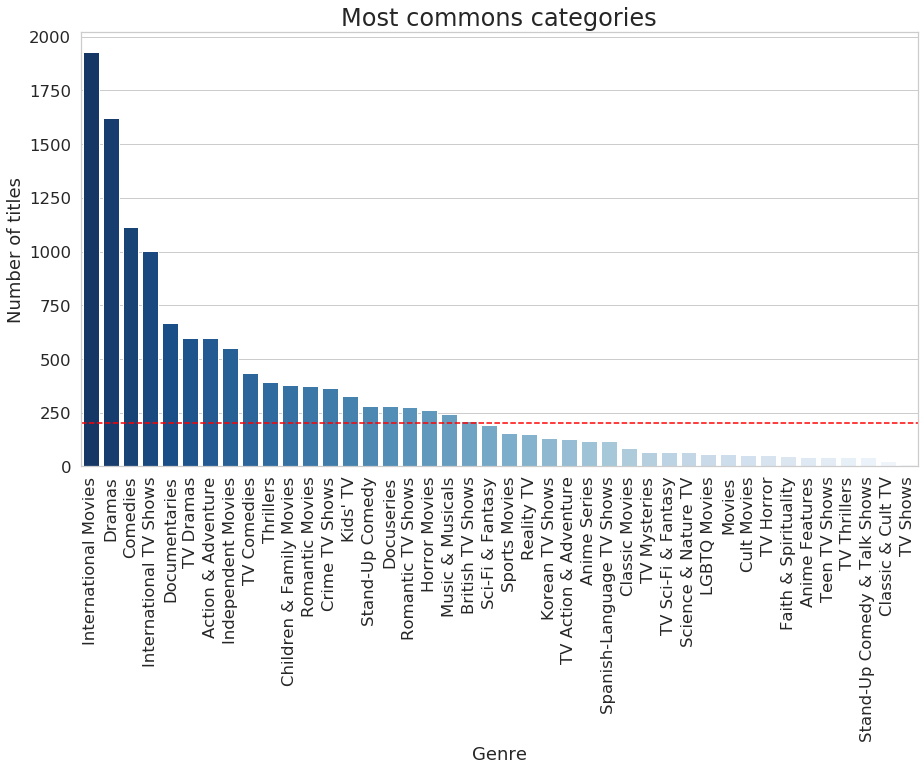

In [346]:
plt.figure(figsize=(15,8))
sns.set(font_scale = 1.5)
sns.set_style('whitegrid') 


pal = sns.color_palette("Blues_r", len(bar_plot))
rank = bar_plot['count'].argsort().argsort()  

sns.barplot(bar_plot['cat'], bar_plot['count'], palette=np.array(pal[::-1])[rank])
plt.axhline(threshold, ls='--', c='red')
plt.title("Most commons categories", fontsize=24)
plt.ylabel('Number of titles', fontsize=18)
plt.xlabel('Genre', fontsize=18)
plt.xticks(rotation='vertical')

plt.show()

In [347]:
main_categories = pd.DataFrame()
main_categories = bar_plot[bar_plot['count']>200]
categories = main_categories['cat'].values
categories = np.append(categories,'Others')
not_category = []
description_category['Others'] = 0

for i in description_category.columns[1:]:
    if i not in categories:
        description_category['Others'][description_category[i] == 1] = 1
        not_category.append(i)

description_category.drop(not_category, axis=1, inplace=True)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


In [348]:
most_common_cat = pd.DataFrame()
most_common_cat['cat'] = description_category.columns[1:]
most_common_cat['count'] = description_category.iloc[:,1:].sum().values
most_common_cat.sort_values(['count'], inplace=True, ascending=False)
most_common_cat.reset_index(inplace=True, drop=True)
most_common_cat.head()

,cat,count
0,International Movies,1927
1,Dramas,1623
2,Others,1574
3,Comedies,1113
4,International TV Shows,1001


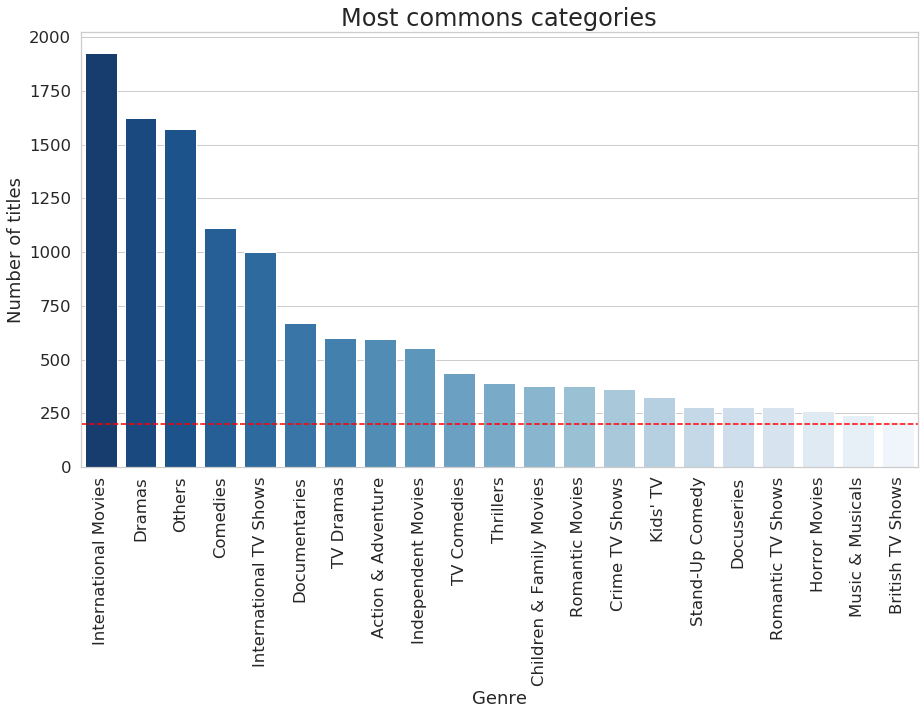

In [349]:
plt.figure(figsize=(15,8))
sns.set(font_scale = 1.5)
sns.set_style('whitegrid') 


pal = sns.color_palette("Blues_r", len(most_common_cat))
rank = most_common_cat['count'].argsort().argsort()  

sns.barplot(most_common_cat['cat'], most_common_cat['count'], palette=np.array(pal[::-1])[rank])
plt.axhline(threshold, ls='--', c='red')
plt.title("Most commons categories", fontsize=24)
plt.ylabel('Number of titles', fontsize=18)
plt.xlabel('Genre', fontsize=18)
plt.xticks(rotation='vertical')

plt.show()

In [350]:
rowSums = description_category.iloc[:,1:].sum(axis=1)
multiLabel_counts = rowSums.value_counts()

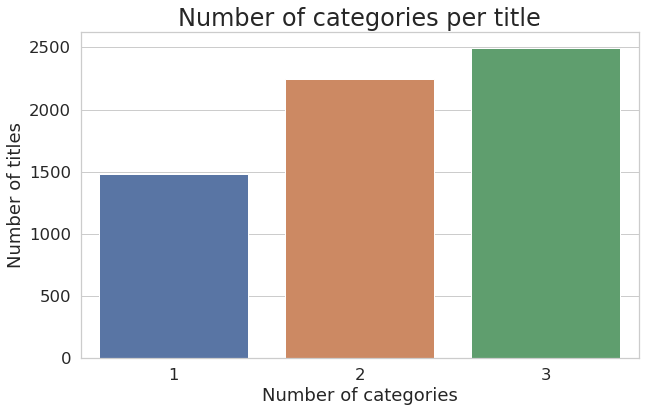

In [351]:
sns.set(font_scale = 1.5)
sns.set_style('whitegrid') 
plt.figure(figsize=(10,6))

sns.barplot(multiLabel_counts.index, multiLabel_counts.values)
plt.title("Number of categories per title", fontsize=24)
plt.ylabel('Number of titles', fontsize=18)
plt.xlabel('Number of categories', fontsize=18)

plt.show()

In [352]:
boxplot = description_category.copy()
boxplot['len'] = description_category.description.apply(lambda x: len(x))

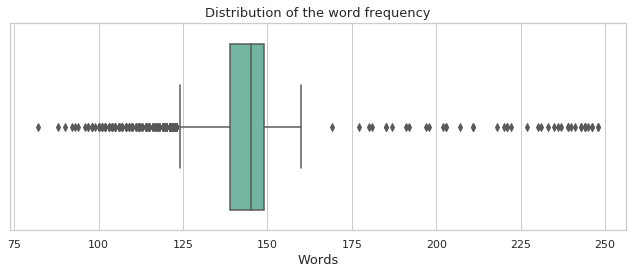

In [353]:
sns.set(style="whitegrid",rc={"font.size":13,"axes.labelsize":13})

plt.figure(figsize=(9, 4))

ax = sns.boxplot(x='len', data=boxplot, orient="h", palette="Set2")
plt.ylabel('')
plt.xlabel('Words')
plt.title("Distribution of the word frequency", fontsize=13)
plt.tight_layout(h_pad=3)

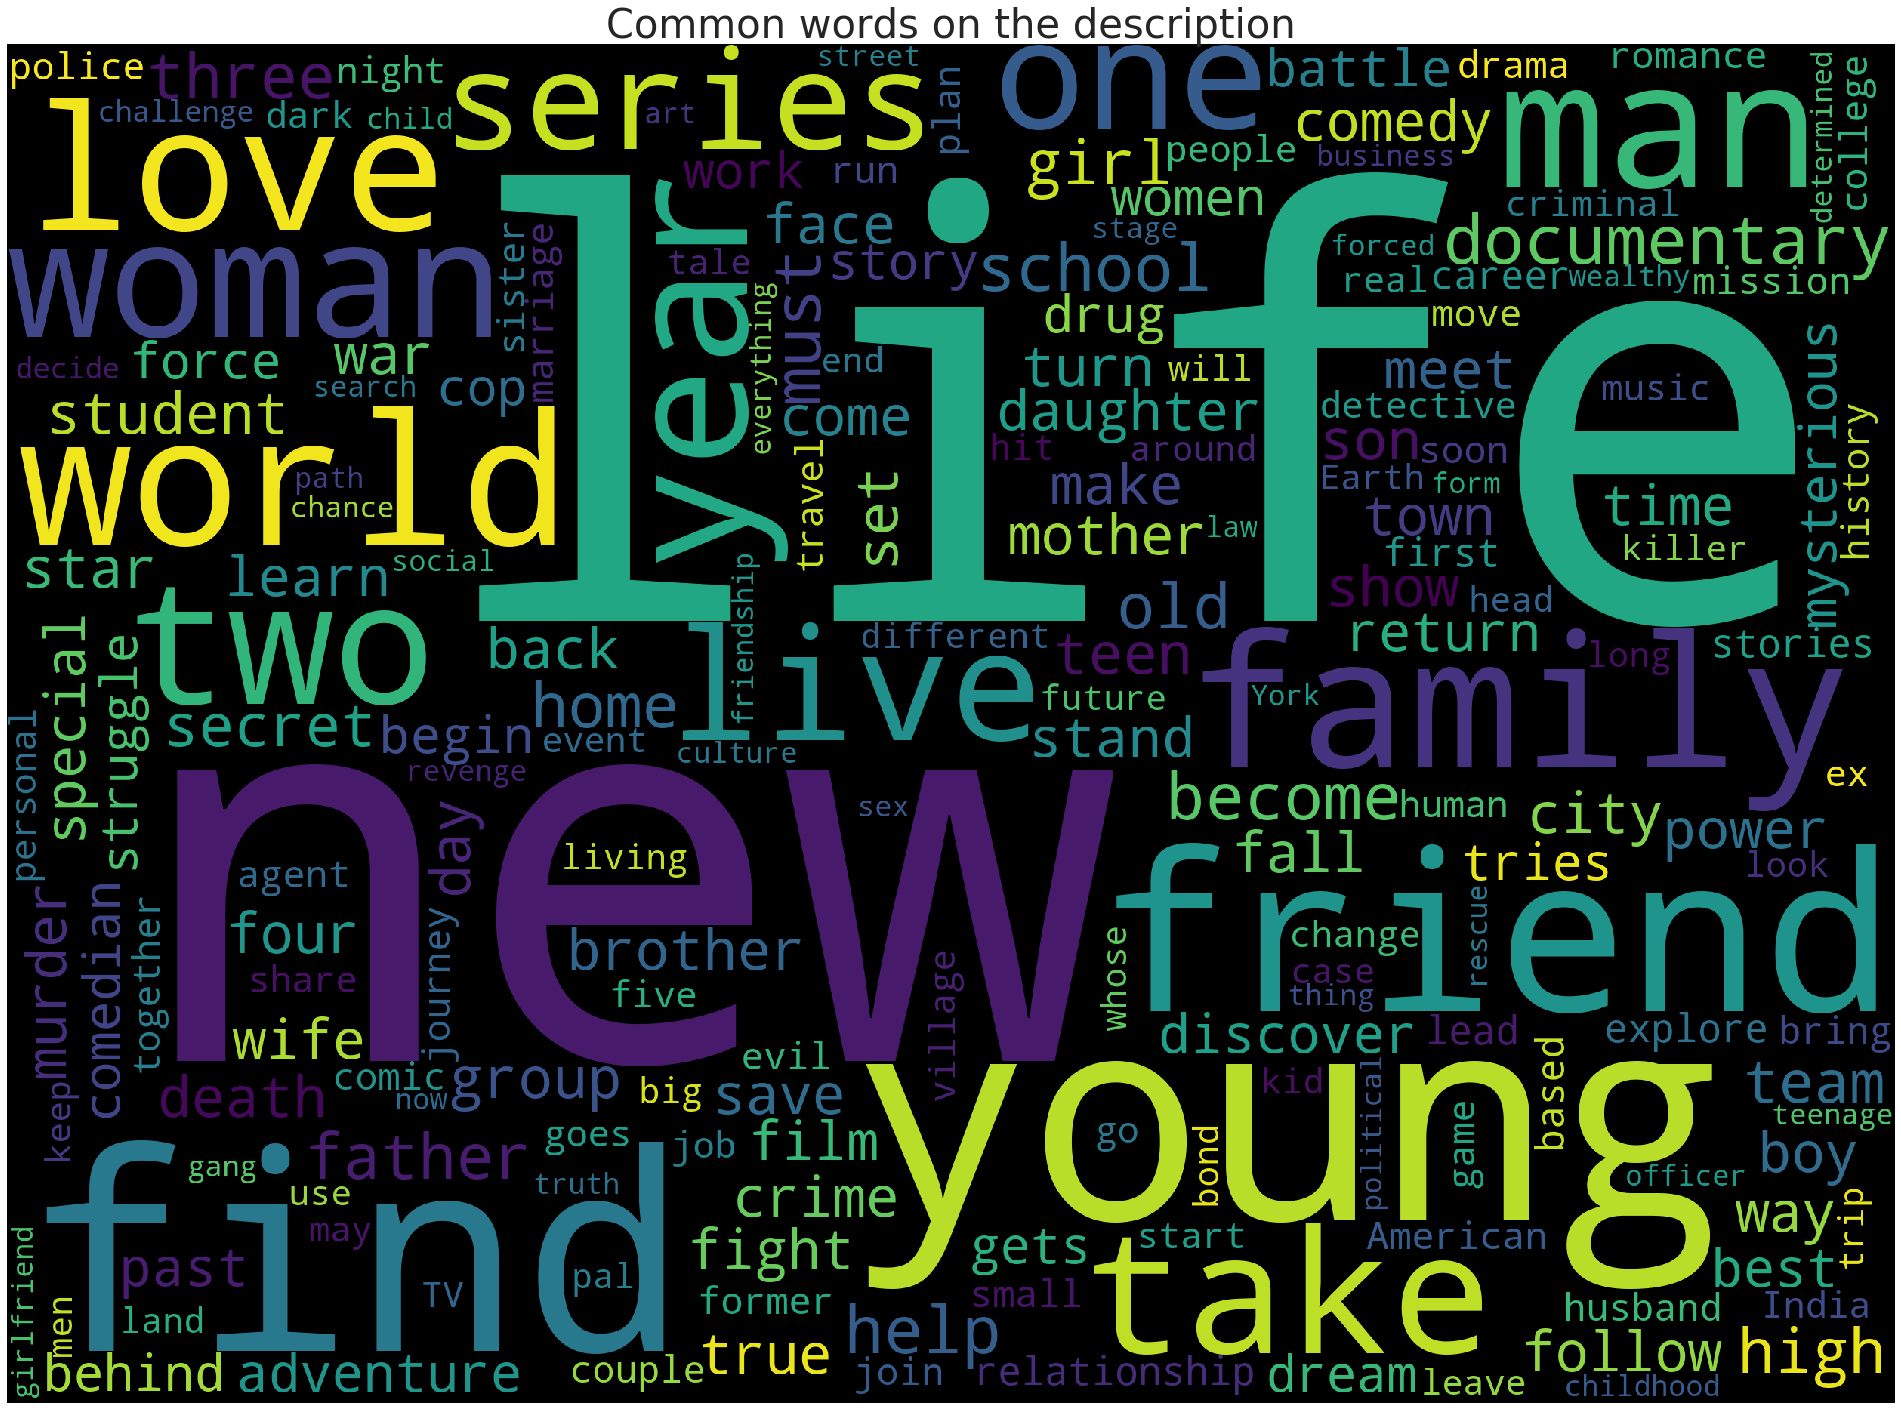

In [354]:
from wordcloud import WordCloud,STOPWORDS

plt.figure(figsize=(40,25))
text = description_category.description.values
cloud = WordCloud(
                          stopwords=STOPWORDS,
                          background_color='black',
                          collocations=False,
                          width=2500,
                          height=1800
                         ).generate(" ".join(text))
plt.axis('off')
plt.title("Common words on the description",fontsize=40)
plt.imshow(cloud)

In [355]:
columns=['OneVsAll', 'BinaryRelevance', 'ClassifierChain', 'MultipleOutput','DNN', 'CNN', 'LSTM']
results = pd.DataFrame(columns = columns)
results

,OneVsAll,BinaryRelevance,ClassifierChain,MultipleOutput,DNN,CNN,LSTM


In [356]:
seeds = [1, 43, 678, 90, 135]

In [357]:
t = results.copy()
t

,OneVsAll,BinaryRelevance,ClassifierChain,MultipleOutput,DNN,CNN,LSTM


## **Preprocessing**

In [358]:
def decontract(sentence):
    # specific
    sentence = re.sub(r"won't", "will not", sentence)
    sentence = re.sub(r"can\'t", "can not", sentence)

    # general
    sentence = re.sub(r"n\'t", " not", sentence)
    sentence = re.sub(r"\'re", " are", sentence)
    sentence = re.sub(r"\'s", " is", sentence)
    sentence = re.sub(r"\'d", " would", sentence)
    sentence = re.sub(r"\'ll", " will", sentence)
    sentence = re.sub(r"\'t", " not", sentence)
    sentence = re.sub(r"\'ve", " have", sentence)
    sentence = re.sub(r"\'m", " am", sentence)
    return sentence

def cleanPunc(sentence): 
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    cleaned = cleaned.strip()
    cleaned = cleaned.replace("\n"," ")
    return cleaned

def keepAlpha(sentence):
    alpha_sent = ""
    for word in sentence.split():
        alpha_word = re.sub('[^a-z A-Z]+', '', word)
        alpha_sent += alpha_word
        alpha_sent += " "
    alpha_sent = alpha_sent.strip()
    return alpha_sent

def removeStopWords(sentence):
    global re_stop_words
    return re_stop_words.sub("", sentence)

In [359]:
stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

re_stop_words = re.compile(r"\b(" + "|".join(stopwords) + ")\\W", re.I)


In [360]:
stemmer = SnowballStemmer("english")
def stemming(sentence):
    stemSentence = ""
    for word in sentence.split():
        stem = stemmer.stem(word)
        stemSentence += stem
        stemSentence += " "
    stemSentence = stemSentence.strip()
    return stemSentence

In [361]:
description_category['description'] = description_category['description'].str.lower()
description_category['description'] = description_category['description'].apply(decontract)
description_category['description'] = description_category['description'].apply(cleanPunc)
description_category['description'] = description_category['description'].apply(keepAlpha)
description_category['description'] = description_category['description'].apply(removeStopWords)
description_category['description'] = description_category['description'].apply(stemming)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(description_category['description'], 
                                                    description_category[description_category.columns[1:]], 
                                                    test_size=0.3, 
                                                    random_state=seeds[4], 
                                                    shuffle=True)
vectorizer = TfidfVectorizer(strip_accents='unicode', analyzer='word', ngram_range=(1,3), norm='l2')
vectorizer.fit(X_train)

X_train = vectorizer.transform(X_train)
X_test = vectorizer.transform(X_test)

## **Models**

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score
from sklearn.multiclass import OneVsRestClassifier


LR_pipeline = Pipeline([('clf', OneVsRestClassifier(LogisticRegression(solver='sag'), n_jobs=-1))])
accuracy = 0
for category in description_category.columns[1:]:
    print('**Processing {} titles...**'.format(category))
    
    # Training logistic regression model on train data
    LR_pipeline.fit(X_train, y_train[category])
    
    # calculating test accuracy
    prediction = LR_pipeline.predict(X_test)
    accuracy = accuracy + accuracy_score(y_test[category], prediction)
    print('AUC ROC score is {}'.format(roc_auc_score(y_test[category],prediction)))
    print("\n")

print('Test averaged AUC ROC is {}'.format(accuracy/len(description_category.columns[1:])))

In [ ]:
from sklearn.naive_bayes import MultinomialNB

NB_pipeline = Pipeline([('clf', OneVsRestClassifier(MultinomialNB(
                    fit_prior=True, class_prior=None)))])
accuracy = 0
for category in description_category.columns[1:]:
    print('**Processing {} titles...**'.format(category))
    
    # Training logistic regression model on train data
    NB_pipeline.fit(X_train, y_train[category])
    
    # calculating test accuracy
    prediction = NB_pipeline.predict(X_test)
    accuracy = accuracy + accuracy_score(y_test[category], prediction)
    print('AUC ROC is {}'.format(roc_auc_score(y_test[category],prediction)))
    print("\n")

print('Test averaged AUC ROC is {}'.format(accuracy/len(description_category.columns[1:])))

In [ ]:
from sklearn.svm import LinearSVC

SVC_pipeline = Pipeline([('clf', OneVsRestClassifier(LinearSVC(), n_jobs=1))])

accuracy = 0
for category in description_category.columns[1:]:
    print('**Processing {} titles...**'.format(category))
    
    # Training logistic regression model on train data
    SVC_pipeline.fit(X_train, y_train[category])
    
    # calculating test accuracy
    prediction = SVC_pipeline.predict(X_test)
    accuracy = accuracy + roc_auc_score(y_test[category], prediction)
    print('F1-score is {}'.format(roc_auc_score(y_test[category],prediction)))
    print("\n")

print('Test averaged f1-score is {}'.format(accuracy/len(description_category.columns[1:])))

In [ ]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.ensemble import RandomForestClassifier

RF_pipeline = Pipeline([('clf', OneVsRestClassifier(RandomForestClassifier(), n_jobs=1))])

accuracy = 0
for category in description_category.columns[1:]:
    print('**Processing {} titles...**'.format(category))
    
    # Training logistic regression model on train data
    RF_pipeline.fit(X_train, y_train[category])
    
    # calculating test accuracy
    prediction = RF_pipeline.predict(X_test)
    accuracy = accuracy + roc_auc_score(y_test[category], prediction)
    print('AUC ROC is {}'.format(roc_auc_score(y_test[category],prediction)))
    print("\n")

print('Test averaged AUC ROC is {}'.format(accuracy/len(description_category.columns[1:])))

In [ ]:
results.loc[4,'OneVsAll'] = accuracy/len(description_category.columns[1:])
results

In [ ]:
from skmultilearn.problem_transform import BinaryRelevance
from sklearn.naive_bayes import GaussianNB

classifier = BinaryRelevance(GaussianNB())
classifier.fit(X_train, y_train)
predictions = classifier.predict(X_test)
accuracy_score(y_test,predictions)
print('AUC ROC is {}'.format(roc_auc_score(y_test,predictions.toarray())))

In [ ]:
results.loc[4,'BinaryRelevance'] = roc_auc_score(y_test,predictions.toarray())
results

In [ ]:
from skmultilearn.problem_transform import ClassifierChain
from sklearn.linear_model import LogisticRegression

classifier = ClassifierChain(LogisticRegression())
classifier.fit(X_train, y_train)
predictions = classifier.predict(X_test)

print('AUC ROC is {}'.format(roc_auc_score(y_test,predictions.toarray())))

In [ ]:
results.loc[4,'ClassifierChain'] = roc_auc_score(y_test,predictions.toarray())
results

In [ ]:
from sklearn.multioutput import MultiOutputClassifier
from sklearn.neighbors import KNeighborsClassifier

clf = MultiOutputClassifier(KNeighborsClassifier()).fit(X_train, y_train)
predictions = clf.predict(X_test)

print('AUC ROC is {}'.format(roc_auc_score(y_test,predictions)))

In [ ]:
results.loc[4,'MultipleOutput'] = roc_auc_score(y_test,predictions)
results

## **Deep Learning**

**Word Embedding**

In [362]:
description_category['description']

0       planning awesome wedding grandfather polar bea...
1       jandino asporaat riffs challenges raising kids...
2       help three human allies autobots protect earth...
3       prison ship crash unleashes hundreds deceptico...
4       nerdy high schooler dani finally attracts inte...
                              ...                        
6229    parody firstperson shooter games military life...
6230    marc maron stars marc maron interviews fellow ...
6231    nursery rhymes original music children accompa...
6232    set russian revolution comic miniseries based ...
6233    hit sitcom follows merry misadventures six som...
Name: description, Length: 6234, dtype: object

In [363]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer(num_words=5000, lower=True)
tokenizer.fit_on_texts(description_category['description'])
sequences = tokenizer.texts_to_sequences(description_category['description'])
x = pad_sequences(sequences, maxlen=200)

In [364]:
X_train, X_test, y_train, y_test = train_test_split(x, 
                                                    description_category[description_category.columns[1:]], 
                                                    test_size=0.3, 
                                                    random_state=seeds[4])

In [ ]:
most_common_cat['class_weight'] = len(most_common_cat) / most_common_cat['count']
class_weight = {}
for index, label in enumerate(categories):
    class_weight[index] = most_common_cat[most_common_cat['cat'] == categories]['class_weight'].values[0]
    
most_common_cat.head()

In [ ]:
num_classes = y_train.shape[1]
max_words = len(tokenizer.word_index) + 1
maxlen = 200

In [ ]:
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

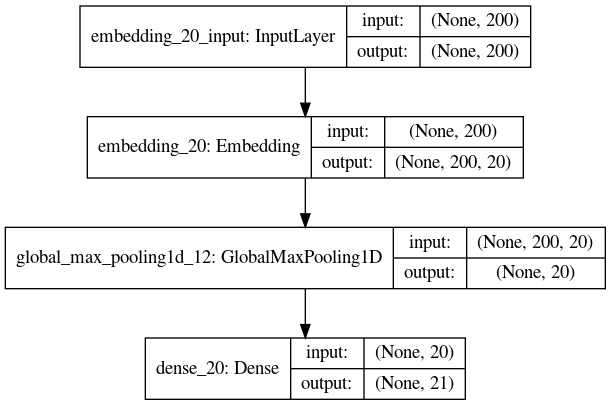

In [301]:
from keras.models import load_model
from keras.models import Sequential
from keras.layers import Dense, Embedding, GlobalMaxPool1D, Dropout
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
import tensorflow as tf

model = Sequential()
model.add(Embedding(max_words, 20, input_length=maxlen))
#model.add(Dropout(0.2))
model.add(GlobalMaxPool1D())
model.add(Dense(num_classes, activation='sigmoid'))

model.compile(optimizer=Adam(0.015), loss='binary_crossentropy', metrics=[tf.keras.metrics.AUC()])
callbacks = [
    ReduceLROnPlateau(),
    #EarlyStopping(patience=10),
    ModelCheckpoint(filepath='model-simple.h5', save_best_only=True)
]


history = model.fit(X_train, y_train,
                    class_weight=class_weight,
                    epochs=30,
                    batch_size=32,
                    validation_split=0.3,
                    callbacks=callbacks)

In [ ]:
cnn_model = model
metrics = cnn_model.evaluate(X_test, y_test)
print("{}: {}".format(cnn_model.metrics_names[1], metrics[1]))

In [ ]:
results.loc[4,'DNN'] = metrics[1]
results

**CNN**

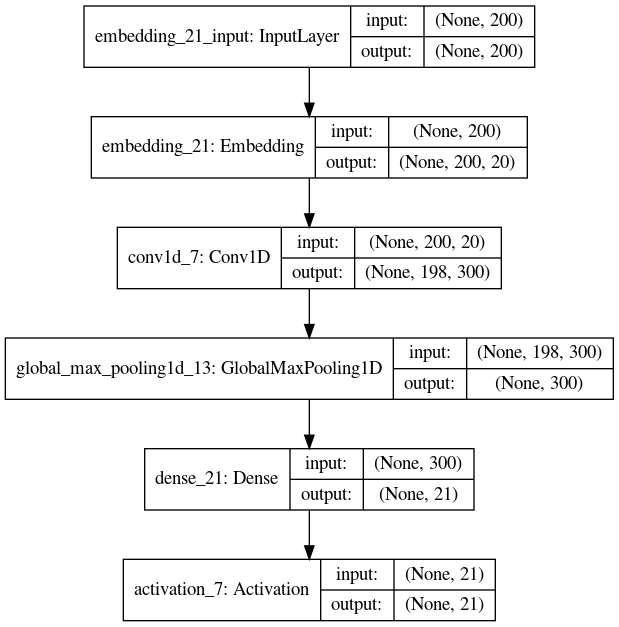

In [302]:
from keras.layers import Dense, Activation, Embedding, Flatten, GlobalMaxPool1D, Dropout, Conv1D

filter_length = 300

model = Sequential()
model.add(Embedding(max_words, 20, input_length=maxlen))
#model.add(Dropout(0.5))
model.add(Conv1D(filter_length, 3, padding='valid', activation='relu', strides=1))
model.add(GlobalMaxPool1D())
model.add(Dense(num_classes))
model.add(Activation('sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[tf.keras.metrics.AUC()])

callbacks = [
    ReduceLROnPlateau(),
    ModelCheckpoint(filepath='model-conv1d.h5', save_best_only=True)
]

history = model.fit(X_train, y_train,
                    class_weight=class_weight,
                    epochs=30,
                    batch_size=32,
                    validation_split=0.3,
                    callbacks=callbacks)

In [ ]:
cnn_model = model
metrics = cnn_model.evaluate(X_test, y_test)
print("{}: {}".format(model.metrics_names[1], metrics[1]))

In [ ]:
results.loc[4,'CNN'] = metrics[1]
results

**GloVe - LSTM** 

In [365]:
from numpy import array
from numpy import asarray
from numpy import zeros

embeddings_dictionary = dict()

glove_file = open('/kaggle/input/glove6b100dtxt/glove.6B.100d.txt', encoding="utf8")

for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = asarray(records[1:], dtype='float32')
    embeddings_dictionary[word] = vector_dimensions
glove_file.close()

embedding_matrix = zeros((max_words, 100))
for word, index in tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

In [366]:
from keras.layers import Input
from keras.layers import Flatten, LSTM
from keras.models import Model

deep_inputs = Input(shape=(maxlen,))
embedding_layer = Embedding(max_words, 100, weights=[embedding_matrix], trainable=False)(deep_inputs)
LSTM_Layer_1 = LSTM(128)(embedding_layer)
dense_layer_1 = Dense(21, activation='sigmoid')(LSTM_Layer_1)
model = Model(inputs=deep_inputs, outputs=dense_layer_1)

callbacks = [
    ReduceLROnPlateau(),
    ModelCheckpoint(filepath='model-conv1d.h5', save_best_only=True)
]

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=[tf.keras.metrics.AUC()])
history = model.fit(X_train, y_train.values,
                    class_weight=class_weight,
                    batch_size=32, 
                    epochs=30, 
                    validation_split=0.3,
                    callbacks=callbacks)

Train on 3054 samples, validate on 1309 samples
Epoch 1/30
3054/3054 [==============================] - 24s 8ms/step - loss: 0.0037 - auc_20: 0.5997 - val_loss: 0.0033 - val_auc_20: 0.6754
Epoch 2/30
3054/3054 [==============================] - 21s 7ms/step - loss: 0.0031 - auc_20: 0.7003 - val_loss: 0.0031 - val_auc_20: 0.7230
Epoch 3/30
3054/3054 [==============================] - 21s 7ms/step - loss: 0.0030 - auc_20: 0.7389 - val_loss: 0.0029 - val_auc_20: 0.7535
Epoch 4/30
3054/3054 [==============================] - 21s 7ms/step - loss: 0.0028 - auc_20: 0.7649 - val_loss: 0.0029 - val_auc_20: 0.7738
Epoch 5/30
3054/3054 [==============================] - 21s 7ms/step - loss: 0.0028 - auc_20: 0.7810 - val_loss: 0.0028 - val_auc_20: 0.7879
Epoch 6/30
3054/3054 [==============================] - 21s 7ms/step - loss: 0.0027 - auc_20: 0.7942 - val_loss: 0.0028 - val_auc_20: 0.7994
Epoch 7/30
3054/3054 [==============================] - 22s 7ms/step - loss: 0.0026 - auc_20: 0.8040 - val

In [367]:
metrics = model.evaluate(X_test, y_test)
print("{}: {}".format(model.metrics_names[1], metrics[1]))

1871/1871 [==============================] - 3s 2ms/step
auc_20: 0.8922807574272156


In [368]:
results.loc[4,'LSTM'] = metrics[1]
results

,OneVsAll,BinaryRelevance,ClassifierChain,MultipleOutput,DNN,CNN,LSTM
4,NaN,NaN,NaN,NaN,NaN,NaN,0.892281


## **Results**

In [ ]:
def highlight_max(data, color='yellow'):
    attr = 'background-color: {}'.format(color)
    if data.ndim == 1:  # Series from .apply(axis=0) or axis=1
        is_max = data == data.max()
        return [attr if v else '' for v in is_max]
    else:  # from .apply(axis=None)
        is_max = data == data.max().max()
        return pd.DataFrame(np.where(is_max, attr, ''),
                            index=data.index, columns=data.columns)

In [ ]:
def highlight_min(data, color='yellow'):
    attr = 'background-color: {}'.format(color)
    if data.ndim == 1:  # Series from .apply(axis=0) or axis=1
        is_min = data == data.min()
        return [attr if v else '' for v in is_min]
    else:  # from .apply(axis=None)
        is_min = data == data.min().min()
        return pd.DataFrame(np.where(is_min, attr, ''),
                            index=data.index, columns=data.columns)

In [ ]:
results.style.apply(highlight_min, color='red', axis=None).apply(highlight_max, color='lightgreen', axis=None)

In [299]:
from matplotlib.colors import LinearSegmentedColormap

#cm = sns.light_palette("green", as_cmap=True)
cm = LinearSegmentedColormap.from_list(
    name='test', 
    #colors=['red','white','green','white','red']
    colors=['tomato','orange','white','lightgreen','green']
)

t = results.apply(pd.to_numeric).style.background_gradient(cmap=cm)
t

,OneVsAll,BinaryRelevance,ClassifierChain,MultipleOutput,DNN,CNN,LSTM
0,0.518714,0.542054,0.517817,0.565078,0.892871,0.887756,0.886272
1,0.517993,0.543217,0.519552,0.565769,0.889736,0.886389,0.886905
2,0.516995,0.544129,0.523836,0.562037,0.889432,0.885472,0.885813
3,0.516779,0.547388,0.520703,0.564256,0.891162,0.882268,0.892583
4,0.515005,0.544417,0.517209,0.565121,0.888024,0.889546,0.886297


In [300]:
def background_gradient(s, m=None, M=None, cmap=cm, low=0, high=0):

    if m is None:
        m = 0.88
    if M is None:
        M = 0.8923
    rng = M - m
    norm = colors.Normalize(m - (rng * low),
                            M + (rng * high))
    normed = s.apply(lambda x: norm(x.values))

    cm = plt.cm.get_cmap(cmap)
    c = normed.applymap(lambda x: colors.rgb2hex(cm(x)))
    ret = c.applymap(lambda x: 'background-color: %s' % x)
    return ret


results.style.apply(background_gradient, axis=None)

,OneVsAll,BinaryRelevance,ClassifierChain,MultipleOutput,DNN,CNN,LSTM
0,0.518714,0.542054,0.517817,0.565078,0.892871,0.887756,0.886272
1,0.517993,0.543217,0.519552,0.565769,0.889736,0.886389,0.886905
2,0.516995,0.544129,0.523836,0.562037,0.889432,0.885472,0.885813
3,0.516779,0.547388,0.520703,0.564256,0.891162,0.882268,0.892583
4,0.515005,0.544417,0.517209,0.565121,0.888024,0.889546,0.886297
